# Solita data tehtava

A jupyter notebook presenting the analysis required for Jaana to make a decision on whether they should take the IC27 train next thursday (10th November) to go see their sons basketball game.

The end product is to create a small application which tells the user what time IC27 is likely to arrive in Tampere

In [31]:
# import necessary python libraries

import matplotlib.pyplot as plt
import numpy as np
import requests
from datetime import datetime, timedelta
import time
import pandas as pd
import json
import os
import sqlite3
from sqlite3 import Error

In [32]:
def create_dir_if_not_exists(dir_):
    """
    simple folder creation
    """
    try:
        os.makedirs(dir_)
    except FileExistsError:
        pass

In [33]:
def json_dump(file_, path):
    """
    dump json files
    """
    with open(path, 'w') as out:
        json.dump(file_, out,indent=2)

In [34]:
def json_load(path):
    """
    Load json Files
    """
    with open(path,'r') as in_:
        f = json.load(in_)
    return f

In [35]:
def get_dates_for_range(range_, today):
    """
    To interact with the API and to define the legth of our analysis we need all the string dates from given ranges
    """
    history_dates = [today - timedelta(days = delta) for delta in range(1,range_)]
    history_dates_str = [x.strftime('%Y-%m-%d') for x in history_dates]
    return history_dates, history_dates_str

## Defining main variables

In [36]:
# Basic variables
train_str = 'IC27'
train_nr = 27
start_station = 'HKI'
end_station = 'TPE'
siirtyma_start = 0
siirtyma_end = 900
nr_days_for_datacollection = 100
nr_days_for_estimate = 100
data_dir = 'juna_data/' # not train_data.... horrendous data science issues
create_dir_if_not_exists(data_dir)



url = 'https://rata.digitraffic.fi/api/v1/trains/{date}/{train_nr}'
today = datetime.today()
history_dates, history_dates_str =  get_dates_for_range(nr_days_for_datacollection, today)

## KYSYMYS 1: Retrieve data from the API

In [37]:
for date in history_dates_str:
    request_url = url.format(date=date,train_nr=train_nr)
    response = requests.get(request_url)
    if not response.ok:
        print('api issue') # change to proper assert error if time
    json_data = response.json()[0]
    save_path = os.path.join(data_dir,date) + '.json'
    json_dump(json_data, save_path)

## KYSYMYS 2: Clean up data and put it in a simple database

Here the database is a simple python dictionar containing the relevant information from the data. Not only relevant information for the current analsysis but also potential further iterations. For example, the times the trains run are not currently used in the estimation, but they could potentially be useful in the future so that information should be saved

In [38]:


# datan siistiminen ja tietokanta

juna_date_dict = {}
# first retrieve information from database:
history_dates_analysis, history_dates_str_analysis =  get_dates_for_range(nr_days_for_estimate, today)
for date in history_dates_str_analysis: # not using same date range as analysis non nec done on whole datanbase
    load_path = os.path.join(data_dir,date) + '.json'
    f = json_load(load_path)
    
    # collect relevant info
    for timeTableRow in f['timeTableRows']:
        if timeTableRow['stationShortCode'] == start_station and timeTableRow['type'] == 'DEPARTURE':
            actual_time_left = timeTableRow['actualTime']
            scheduled_time_left = timeTableRow['scheduledTime']
        elif timeTableRow['stationShortCode'] == end_station and timeTableRow['type'] == 'ARRIVAL':
            actual_time_arrived = timeTableRow['actualTime']
            scheduled_time_arrived = timeTableRow['scheduledTime']
            difference_in_time = timeTableRow['differenceInMinutes']
    juna_date_dict[date] = {
        'actual_time_left': actual_time_left,
        'scheduled_time_left': scheduled_time_left,
        'actual_time_arrived': actual_time_arrived,
        'scheduled_time_arrived': scheduled_time_arrived,
        'difference_in_time': difference_in_time
                                }


In [39]:
def create_connection(db_file):
    """ create a database connection to a SQLite database """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
    except Error as e:
        print(e)
#     finally:
#         if conn:
#             conn.close()
    return conn

In [40]:
conn = create_connection('trains.db') # just use ram as its small data


2.6.0


In [41]:
create_table_str = """
CREATE TABLE IF NOT EXISTS train_data (
	tripdate DATETIME PRIMARY KEY NOT NULL,
	train_id integer NOT NULL,
	actual_time_left DATETIME NOT NULL,
	scheduled_time_left DATETIME NOT NULL,
	actual_time_arrived DATETIME NOT NULL,
	scheduled_time_arrived DATETIME NOT NULL,
	difference_in_time DATETIME NOT NULL
);
"""


In [42]:
if conn is not None:
    try:
        c = conn.cursor()
        c.execute(create_table_str)
    except Error as e:
        print(e)

else:
    print("Error! cannot create the database connection.")

In [43]:
def insert_trip(conn, trip):
    """
    Create a new task
    :param conn:
    :param task:
    :return:
    """

    sql = ''' INSERT INTO train_data(tripdate,train_id,actual_time_left,scheduled_time_left,actual_time_arrived,scheduled_time_arrived,difference_in_time)
              VALUES(?,?,?,?,?,?,?) '''
    cur = conn.cursor()
    cur.execute(sql, trip)
    conn.commit()

    return cur.lastrowid

In [44]:
def fetch_from_db(conn,q):
    cur = conn.cursor()
    cur.execute(q)
    rows = cur.fetchall()
    return rows

In [45]:
for key, values in juna_date_dict.items():
    to_insert = (key, 27, 
           values['actual_time_left'], 
           values['scheduled_time_left'],
           values['actual_time_arrived'], 
           values['scheduled_time_arrived'],
           values['difference_in_time'])
    try:
        insert_trip(conn, to_insert)
    except: # error handing to be made better
        print('trip: {} already exists'.format(key))

trip: 2023-11-02 already exists
trip: 2023-11-01 already exists
trip: 2023-10-31 already exists
trip: 2023-10-30 already exists
trip: 2023-10-29 already exists
trip: 2023-10-28 already exists
trip: 2023-10-27 already exists
trip: 2023-10-26 already exists
trip: 2023-10-25 already exists
trip: 2023-10-24 already exists
trip: 2023-10-23 already exists
trip: 2023-10-22 already exists
trip: 2023-10-21 already exists
trip: 2023-10-20 already exists
trip: 2023-10-19 already exists
trip: 2023-10-18 already exists
trip: 2023-10-17 already exists
trip: 2023-10-16 already exists
trip: 2023-10-15 already exists
trip: 2023-10-14 already exists
trip: 2023-10-13 already exists
trip: 2023-10-12 already exists
trip: 2023-10-11 already exists
trip: 2023-10-10 already exists
trip: 2023-10-09 already exists
trip: 2023-10-08 already exists
trip: 2023-10-07 already exists
trip: 2023-10-06 already exists
trip: 2023-10-05 already exists
trip: 2023-10-04 already exists
trip: 2023-10-03 already exists
trip: 20

# KYSYMYS 3 ja 4: Ennuste ja perustelut Saapumis ajasta

The easiest way to predict the actual arrival time of IC27 is to look whether it is usually on time. Meaning we are interested in the distribution of the amount of lateness of the trains. For this the difference in time variable provided by the API is very useful. 

### First we draw the distribution of the difference_in_time variable over the chosen time period.

(array([ 5., 19., 47.,  9.,  6.,  2.,  3.,  1.,  0.,  3.,  1.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([-3.        , -1.56666667, -0.13333333,  1.3       ,  2.73333333,
         4.16666667,  5.6       ,  7.03333333,  8.46666667,  9.9       ,
        11.33333333, 12.76666667, 14.2       , 15.63333333, 17.06666667,
        18.5       , 19.93333333, 21.36666667, 22.8       , 24.23333333,
        25.66666667, 27.1       , 28.53333333, 29.96666667, 31.4       ,
        32.83333333, 34.26666667, 35.7       , 37.13333333, 38.56666667,
        40.        ]),
 <BarContainer object of 30 artists>)

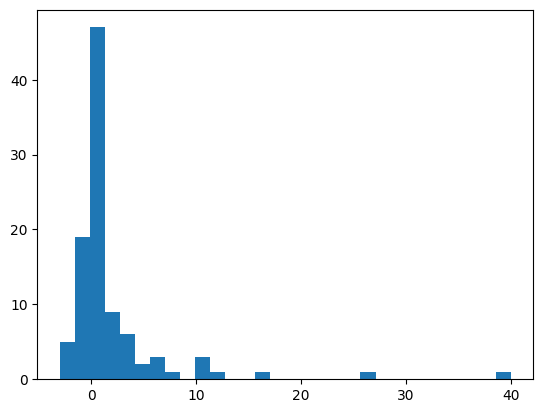

In [46]:
# to_draw = []
to_draw = [x[0] for x in fetch_from_db(conn,'select difference_in_time from train_data')]
to_draw = sorted(to_draw)
plt.hist(to_draw,bins=30)

From the graph we can see that usually the train is either on time or a few minutes late. It is worth zooming to the left side of the figure to understand the distribution better

(array([ 1.,  4.,  0., 19., 25.,  0., 22.,  9.,  0.,  3.,  0.,  3.,  2.,
         0.,  1.,  2.,  0.,  1.,  0.,  0.,  2.,  0.,  1.,  1.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([-3.        , -2.36666667, -1.73333333, -1.1       , -0.46666667,
         0.16666667,  0.8       ,  1.43333333,  2.06666667,  2.7       ,
         3.33333333,  3.96666667,  4.6       ,  5.23333333,  5.86666667,
         6.5       ,  7.13333333,  7.76666667,  8.4       ,  9.03333333,
         9.66666667, 10.3       , 10.93333333, 11.56666667, 12.2       ,
        12.83333333, 13.46666667, 14.1       , 14.73333333, 15.36666667,
        16.        ]),
 <BarContainer object of 30 artists>)

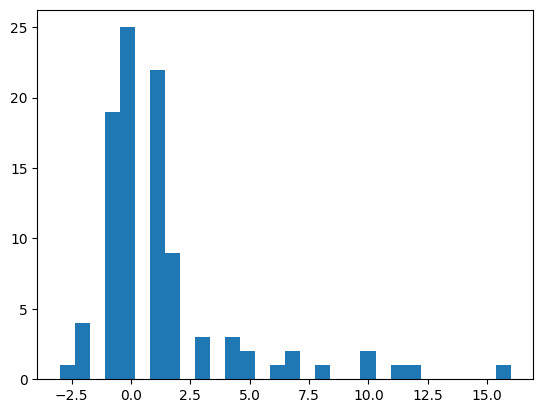

In [47]:
# to_draw = []
to_draw_zoom = [x[0] for x in fetch_from_db(conn,'select difference_in_time from train_data where difference_in_time < 20')]
# to_draw_zoom = [x for x in to_draw if x < 20] # zoom
to_draw_zoom = sorted(to_draw_zoom)
plt.hist(to_draw_zoom,bins=30)

### So how late is the train on average?

In [48]:
print('On average the train is {} minutes late'.format(round(np.mean(to_draw),2)))

On average the train is 1.96 minutes late


Train is scheduled to arrive at 15:58 next Thursday. Based on our estimate the train should arrive at 16:00, since on average it is about 2 minutest late.



A more useful metric for Jaana might be the probability of her being on time for the game:

In [49]:
print('The probability of Jaana being on time for the game is {}'.format(
        round(len([x for x in to_draw if x <2]) / len(to_draw),2))
     )

The probability of Jaana being on time for the game is 0.72


## KYSYMYS 5: Separate File (sovellus.py)